In [1]:
import os

import torch
import torch.nn as nn

from skelcast.data.dataset import NTURGBDDataset

DATA_DIR = os.environ['NTU_RGBD_DATA_DIR']
MISSING_FILES_DIR = '../data/missing'

if not DATA_DIR:
    raise ValueError("NTU_RGBD_DATA_DIR environment variable is not set or empty.")

In [2]:
from skelcast.data.transforms import MinMaxScaleTransform
transform = MinMaxScaleTransform(feature_scale=(0.0, 1.0))
dataset = NTURGBDDataset(data_directory=DATA_DIR, missing_files_dir=MISSING_FILES_DIR, max_context_window=2, max_number_of_bodies=1, transforms=transform)

sample = dataset[0]

nturgb_d.txt
nturgb_d_120.txt
Skeleton files after filtering: 114478 files left.


In [3]:
from skelcast.data.dataset import NTURGBDCollateFn

collate_fn = NTURGBDCollateFn(block_size=16)
data_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=16, collate_fn=collate_fn)

for batch in data_loader:
    print(f'x shape: {batch.x.shape}')

x shape: torch.Size([16, 16, 1, 25, 3])
x shape: torch.Size([16, 16, 1, 25, 3])
x shape: torch.Size([16, 16, 1, 25, 3])
x shape: torch.Size([16, 16, 1, 25, 3])
x shape: torch.Size([16, 16, 1, 25, 3])
x shape: torch.Size([16, 16, 1, 25, 3])
x shape: torch.Size([16, 16, 1, 25, 3])
x shape: torch.Size([16, 16, 1, 25, 3])
x shape: torch.Size([16, 16, 1, 25, 3])
x shape: torch.Size([16, 16, 1, 25, 3])
x shape: torch.Size([16, 16, 1, 25, 3])
x shape: torch.Size([16, 16, 1, 25, 3])
x shape: torch.Size([16, 16, 1, 25, 3])
x shape: torch.Size([16, 16, 1, 25, 3])
x shape: torch.Size([16, 16, 1, 25, 3])
x shape: torch.Size([16, 16, 1, 25, 3])
x shape: torch.Size([16, 16, 1, 25, 3])
x shape: torch.Size([16, 16, 1, 25, 3])
x shape: torch.Size([16, 16, 1, 25, 3])
x shape: torch.Size([16, 16, 1, 25, 3])
x shape: torch.Size([16, 16, 1, 25, 3])
x shape: torch.Size([16, 16, 1, 25, 3])
x shape: torch.Size([16, 16, 1, 25, 3])
x shape: torch.Size([16, 16, 1, 25, 3])
x shape: torch.Size([16, 16, 1, 25, 3])


RuntimeError: random_ expects 'from' to be less than 'to', but got from=0 >= to=-1

In [5]:
a = torch.randn((78, 2, 1, 25, 3))
b = torch.randn((32, 2, 1, 25, 3))
c = torch.randn([63, 2, 1, 25, 3])

d = torch.cat([a, b, c], dim=0)
print(d.shape)

torch.Size([173, 2, 1, 25, 3])


type of sequence: <class 'dict'>
keys: dict_keys(['file_name', 'nbodys', 'njoints', 'skel_body0', 'rgb_body0', 'depth_body0', 'skel_body1', 'rgb_body1', 'depth_body1'])
shape of x: (78, 25, 3)


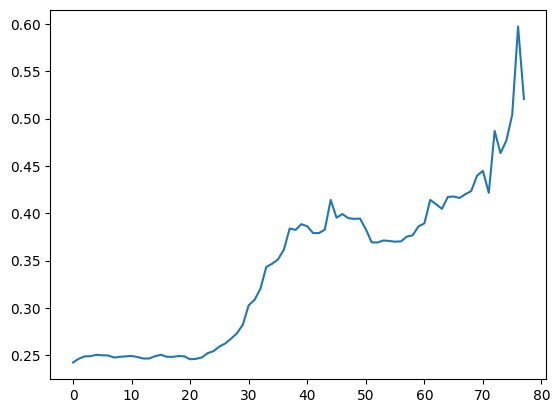

In [3]:
from skelcast.data.dataset import read_skeleton_file

fname = dataset.skeleton_files_clean[0]

sequence = read_skeleton_file(fname)
print(f'type of sequence: {type(sequence)}')
print(f'keys: {sequence.keys()}')
x = sequence['skel_body0']
print(f'shape of x: {x.shape}') # T x N_joints x 3

import matplotlib.pyplot as plt

plt.plot(x[:, 0, 0])
# plt.plot(x[:, 0, 1])
# plt.plot(x[:, 0, 2])
plt.show()

In [4]:
import numpy as np


def get_windows(input_sequence, context_size=20) -> tuple:
    seq_len = input_sequence.shape[0]
    input_windows = []
    target_labels = []
    for i in range(seq_len - context_size):
        window = input_sequence[i:i + context_size, ...]
        target_label = input_sequence[i + context_size, ...]
        input_windows.append(window)
        target_labels.append(target_label)
    # print(target_labels)
    input_windows_tensor = torch.tensor(input_windows, dtype=torch.float).unsqueeze(0).unsqueeze(-1)
    target_labels_tensor = torch.tensor(np.array(target_labels), dtype=torch.float).unsqueeze(0)
    return input_windows_tensor, target_labels_tensor

In [9]:
x[:, 0, 0].shape

(78,)

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(x[:, 0, 0].reshape(-1, 1))
print(scaled.shape)
inp_windows, target_labels = get_windows((scaled), context_size=2)

(78, 1)


/tmp/ipykernel_283149/1747706672.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  input_windows_tensor = torch.tensor(input_windows, dtype=torch.float).unsqueeze(0).unsqueeze(-1)


In [6]:
print(f'Input windows shape: {inp_windows.shape}')
print(f'Labels shape: {target_labels.shape}')

Input windows shape: torch.Size([1, 76, 2, 1, 1])
Labels shape: torch.Size([1, 76, 1])


In [7]:
# Let's say I only want to predict the first joint's location in the future in the x-axis
joint_1_location_x = inp_windows[0, :, :, :, 0]
joint_1_targets = target_labels[..., 0].permute(1, 0)
print(f'INput windows shape: {joint_1_location_x.shape}')
print(f'Labels shape: {joint_1_targets.shape} ')

INput windows shape: torch.Size([76, 2, 1])
Labels shape: torch.Size([76, 1]) 


In [8]:
class SimpleLSTMRegressor(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=2) -> None:
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.linear = nn.Linear(in_features=hidden_size, out_features=1)
    
    def forward(self, x):
        # self.lstm.flatten_parameters()
        out, _ = self.lstm(x)
        return self.linear(out[:, -1, :])

In [9]:
model = SimpleLSTMRegressor(input_size=1, hidden_size=2048)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
criterion = torch.nn.MSELoss()
criterion = criterion.to(device=device)

model = model.to(device=device)

N_EPOCHS = 10000

joint_1_location_x = joint_1_location_x.to(device)
joint_1_targets = joint_1_targets.to(device)
loss_history = []

In [10]:
for epoch in range(N_EPOCHS):
    print(f'epoch: {epoch + 1}')
    predictions = model(joint_1_location_x)
    print(f'predictions shpae: {predictions.shape}')
    loss = criterion(predictions, joint_1_targets)
    print(f'loss: {loss.item()}')
    loss_history.append(loss.item())
    print(f'prediction: {predictions[0]}, actual: {joint_1_targets[0, 0]}')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

epoch: 1
predictions shpae: torch.Size([76, 1])
loss: 0.37811365723609924
prediction: tensor([-0.0160], device='cuda:0', grad_fn=<SelectBackward0>), actual: -0.963805079460144
epoch: 2
predictions shpae: torch.Size([76, 1])
loss: 0.37796035408973694
prediction: tensor([-0.0162], device='cuda:0', grad_fn=<SelectBackward0>), actual: -0.963805079460144
epoch: 3
predictions shpae: torch.Size([76, 1])
loss: 0.37780746817588806
prediction: tensor([-0.0164], device='cuda:0', grad_fn=<SelectBackward0>), actual: -0.963805079460144
epoch: 4
predictions shpae: torch.Size([76, 1])
loss: 0.3776543140411377
prediction: tensor([-0.0166], device='cuda:0', grad_fn=<SelectBackward0>), actual: -0.963805079460144
epoch: 5
predictions shpae: torch.Size([76, 1])
loss: 0.3775012791156769
prediction: tensor([-0.0168], device='cuda:0', grad_fn=<SelectBackward0>), actual: -0.963805079460144
epoch: 6
predictions shpae: torch.Size([76, 1])
loss: 0.3773484528064728
prediction: tensor([-0.0170], device='cuda:0', gr

In [11]:
predictions = model(joint_1_location_x)
predictions_np = predictions.detach().cpu().numpy()
actuals = joint_1_targets.detach().cpu().numpy()

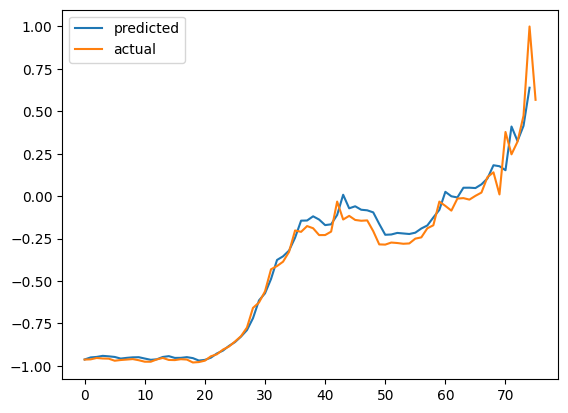

In [12]:
x = np.arange(0, predictions_np.shape[0])
plt.plot(predictions_np[1:])
plt.plot(actuals)
plt.legend(['predicted', 'actual'])
plt.show()

In [38]:
joint_1_location_x[0, 1, 0]

tensor(-0.9773, device='cuda:0')

In [47]:
joint_1_location_x.shape

torch.Size([76, 2, 1])

(40,)